# So sánh: Nhãn Gốc vs Nhãn Annotate Lại (MAFA)

Notebook này so sánh hiệu năng của mô hình Logistic Regression khi train trên:
1. **Original Labels**: train.csv + val.csv (nhãn gốc)
2. **Re-annotated Labels**: train_labeled.csv + val_labeled.csv (nhãn từ MAFA agents)

Mục tiêu: Đánh giá xem việc annotate lại bằng MAFA có cải thiện chất lượng dữ liệu không.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    accuracy_score, precision_score, recall_score
)

# Cấu hình hiển thị
pd.set_option('display.max_colwidth', 200)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Tải dữ liệu

In [31]:
# Dữ liệu gốc (Original)
train_orig = pd.read_csv('../data/train.csv')
val_orig = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

# Dữ liệu annotate lại (MAFA)
train_reann = pd.read_csv('../data/train_labeled.csv')
val_reann = pd.read_csv('../data/val_labeled.csv')

print("=== ORIGINAL DATA ===")
print(f"Train: {len(train_orig)} samples")
print(f"Val: {len(val_orig)} samples")
print(f"Test: {len(test_df)} samples")

print("\n=== RE-ANNOTATED DATA (MAFA) ===")
print(f"Train: {len(train_reann)} samples")
print(f"Val: {len(val_reann)} samples")

# Kiểm tra cấu trúc
print("\n=== COLUMNS ===")
print(f"Original train: {train_orig.columns.tolist()}")
print(f"Re-annotated train: {train_reann.columns.tolist()}")

=== ORIGINAL DATA ===
Train: 4387 samples
Val: 548 samples
Test: 549 samples

=== RE-ANNOTATED DATA (MAFA) ===
Train: 4387 samples
Val: 548 samples

=== COLUMNS ===
Original train: ['Unnamed: 0', 'review', 'review_tokenize', 'label', 'domain']
Re-annotated train: ['review', 'label', 'source', 'confidence', 'decision']


## 2. Phân tích sự khác biệt giữa 2 bộ nhãn

In [32]:
# So sánh nhãn trên tập train
print("=== SO SÁNH NHÃN TRÊN TRAIN ===")

# Lấy cột text và label từ cả 2
train_orig_compare = train_orig[['review', 'label']].copy()
train_orig_compare.columns = ['text', 'label_orig']
train_orig_compare['label_orig'] = train_orig_compare['label_orig'].astype(int)

train_reann_compare = train_reann[['review', 'label']].copy()
train_reann_compare.columns = ['text', 'label_reann']

# Merge để so sánh
train_compare = pd.merge(
    train_orig_compare, 
    train_reann_compare, 
    on='text', 
    how='inner'
)

print(f"Số samples có thể so sánh: {len(train_compare)} / {len(train_orig)}")

# Tính độ khớp nhau
matches = (train_compare['label_orig'] == train_compare['label_reann']).sum()
agreement_rate = matches / len(train_compare) * 100

print(f"\nAgreement rate: {agreement_rate:.2f}% ({matches}/{len(train_compare)})")
print(f"Disagreement: {len(train_compare) - matches} samples")

=== SO SÁNH NHÃN TRÊN TRAIN ===
Số samples có thể so sánh: 4408 / 4387

Agreement rate: 93.56% (4124/4408)
Disagreement: 284 samples


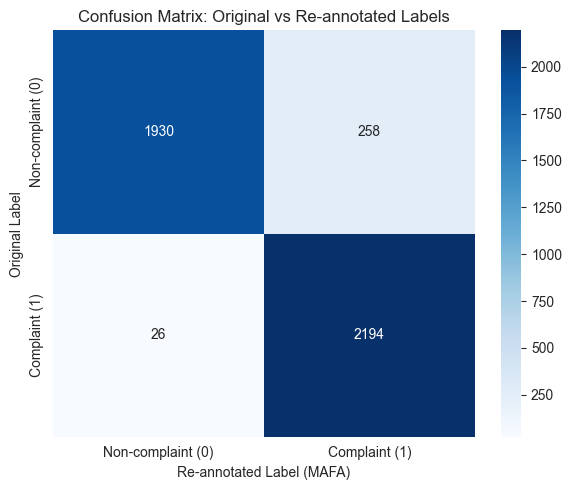


Chi tiết:
- Cùng label 0: 1930 samples
- Cùng label 1: 2194 samples
- Original 0 -> Re-ann 1: 258 samples (MAFA thêm complaint)
- Original 1 -> Re-ann 0: 26 samples (MAFA bỏ complaint)


In [33]:
# Confusion matrix giữa nhãn gốc và nhãn mới
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(train_compare['label_orig'], train_compare['label_reann'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-complaint (0)', 'Complaint (1)'],
            yticklabels=['Non-complaint (0)', 'Complaint (1)'])
plt.xlabel('Re-annotated Label (MAFA)')
plt.ylabel('Original Label')
plt.title('Confusion Matrix: Original vs Re-annotated Labels')
plt.tight_layout()
plt.show()

print("\nChi tiết:")
print(f"- Cùng label 0: {cm[0,0]} samples")
print(f"- Cùng label 1: {cm[1,1]} samples")
print(f"- Original 0 -> Re-ann 1: {cm[0,1]} samples (MAFA thêm complaint)")
print(f"- Original 1 -> Re-ann 0: {cm[1,0]} samples (MAFA bỏ complaint)")

In [34]:
# Xem các samples bị thay đổi nhãn
disagree_samples = train_compare[
    train_compare['label_orig'] != train_compare['label_reann']
]

print(f"=== CÁC SAMPLES BỊ THAY ĐỔI NHÃN ({len(disagree_samples)}) ===")

# Original 0 -> Re-ann 1
orig0_reann1 = disagree_samples[
    (disagree_samples['label_orig'] == 0) & 
    (disagree_samples['label_reann'] == 1)
]
print(f"\n1. Original 0 -> Re-annotated 1 ({len(orig0_reann1)} samples):")
for idx, row in orig0_reann1.head(5).iterrows():
    print(f"   - {row['text']}")

# Original 1 -> Re-ann 0
orig1_reann0 = disagree_samples[
    (disagree_samples['label_orig'] == 1) & 
    (disagree_samples['label_reann'] == 0)
]
print(f"\n2. Original 1 -> Re-annotated 0 ({len(orig1_reann0)} samples):")
for idx, row in orig1_reann0.head(5).iterrows():
    print(f"   - {row['text']}")

=== CÁC SAMPLES BỊ THAY ĐỔI NHÃN (284) ===

1. Original 0 -> Re-annotated 1 (258 samples):
   - vải đẹp lắm giá lại rẻ cho  cửa hàng  một 1star  luon
   - sản phẩm như mong đợi , có thêm 2 chức năng nữa :  kháng nước ip68 và xài được 5g   nữa thì càng tuyệt vời hơn
   - kích hoạt bảo hành điện tử như thế này vậy  cửa hàng .
   - tot. goi hang can than
   - hang  đẹp   gì không hình👌

2. Original 1 -> Re-annotated 0 (26 samples):
   - game hay. ít nhiệm vụ lấy đồ để cày hơn.. thực tiễn hơn.. không như mấy game khác nhiệm vụ cho đồ khác thì theo một khuôn khổ chán quá trời ra..
   - bi za mo hoi
   - lần đầu đặt loại vải này nhưng rất ưng, vải kate nhưng mềm mịn không bị thô,đg chỉ hơi mỏng nhưng mọi người thông cảm tiền nào của nấy nha mọi người nhận hàng chịu khó đem ra tiệm cho ngt đạp lại 1đg chỉ nữa là tốt r😊k bị lỗi chỗ nào hàng tốt được ủng hộ dài dài😍👌
   - da mình nhạy cảm nhưng dùng em này cũng ok! giá thành hơi mắc nhưng xứng với giá tiền.
   - hơi rộng nhưng mà rất đẹp😊


## 3. Chuẩn bị dữ liệu cho training

In [35]:
# Hàm tiền xử lý text đơn giản
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = str(text).lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Dataset 1: Original labels
X_train_orig = train_orig['review'].apply(preprocess_text)
y_train_orig = train_orig['label'].astype(int)

X_val_orig = val_orig['review'].apply(preprocess_text)
y_val_orig = val_orig['label'].astype(int)

# Dataset 2: Re-annotated labels
# Cột text trong train_labeled/val_labeled là 'review'
X_train_reann = train_reann['review'].apply(preprocess_text)
y_train_reann = train_reann['label'].astype(int)

X_val_reann = val_reann['review'].apply(preprocess_text)
y_val_reann = val_reann['label'].astype(int)

# Test set (giữ nguyên)
X_test = test_df['review'].apply(preprocess_text)
y_test = test_df['label'].astype(int)

print("Data prepared successfully!")
print(f"\nOriginal - Train: {len(X_train_orig)}, Val: {len(X_val_orig)}")
print(f"Re-annotated - Train: {len(X_train_reann)}, Val: {len(X_val_reann)}")
print(f"Test: {len(X_test)}")

Data prepared successfully!

Original - Train: 4387, Val: 548
Re-annotated - Train: 4387, Val: 548
Test: 549


## 4. Training & Evaluation

In [36]:
# Hàm train và evaluate
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, label_name):
    """
    Train model và trả về kết quả evaluation
    """
    # Tạo pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=2
        )),
        ('clf', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        ))
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)
    
    # Metrics
    results = {
        'label_type': label_name,
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred, average='weighted'),
        'val_f1_macro': f1_score(y_val, y_val_pred, average='macro'),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred, average='weighted'),
        'test_f1_macro': f1_score(y_test, y_test_pred, average='macro'),
        'test_precision': precision_score(y_test, y_test_pred, average='weighted'),
        'test_recall': recall_score(y_test, y_test_pred, average='weighted'),
        'y_test_pred': y_test_pred
    }
    
    return results, pipeline

# Train với original labels
print("Training with ORIGINAL labels...")
results_orig, model_orig = train_and_evaluate(
    X_train_orig, y_train_orig,
    X_val_orig, y_val_orig,
    X_test, y_test,
    "Original"
)
print("Done!")

# Train với re-annotated labels
print("\nTraining with RE-ANNOTATED labels...")
results_reann, model_reann = train_and_evaluate(
    X_train_reann, y_train_reann,
    X_val_reann, y_val_reann,
    X_test, y_test,
    "MAFA Re-annotated"
)
print("Done!")

Training with ORIGINAL labels...
Done!

Training with RE-ANNOTATED labels...
Done!


## 5. So sánh kết quả

In [37]:
# Tạo bảng so sánh
comparison_df = pd.DataFrame([
    {
        'Metric': 'Validation Accuracy',
        'Original': f"{results_orig['val_accuracy']:.4f}",
        'MAFA Re-annotated': f"{results_reann['val_accuracy']:.4f}",
        'Difference': f"{results_reann['val_accuracy'] - results_orig['val_accuracy']:+.4f}"
    },
    {
        'Metric': 'Validation F1 (Weighted)',
        'Original': f"{results_orig['val_f1']:.4f}",
        'MAFA Re-annotated': f"{results_reann['val_f1']:.4f}",
        'Difference': f"{results_reann['val_f1'] - results_orig['val_f1']:+.4f}"
    },
    {
        'Metric': 'Validation F1 (Macro)',
        'Original': f"{results_orig['val_f1_macro']:.4f}",
        'MAFA Re-annotated': f"{results_reann['val_f1_macro']:.4f}",
        'Difference': f"{results_reann['val_f1_macro'] - results_orig['val_f1_macro']:+.4f}"
    },
    {
        'Metric': 'Test Accuracy',
        'Original': f"{results_orig['test_accuracy']:.4f}",
        'MAFA Re-annotated': f"{results_reann['test_accuracy']:.4f}",
        'Difference': f"{results_reann['test_accuracy'] - results_orig['test_accuracy']:+.4f}"
    },
    {
        'Metric': 'Test F1 (Weighted)',
        'Original': f"{results_orig['test_f1']:.4f}",
        'MAFA Re-annotated': f"{results_reann['test_f1']:.4f}",
        'Difference': f"{results_reann['test_f1'] - results_orig['test_f1']:+.4f}"
    },
    {
        'Metric': 'Test F1 (Macro)',
        'Original': f"{results_orig['test_f1_macro']:.4f}",
        'MAFA Re-annotated': f"{results_reann['test_f1_macro']:.4f}",
        'Difference': f"{results_reann['test_f1_macro'] - results_orig['test_f1_macro']:+.4f}"
    },
    {
        'Metric': 'Test Precision',
        'Original': f"{results_orig['test_precision']:.4f}",
        'MAFA Re-annotated': f"{results_reann['test_precision']:.4f}",
        'Difference': f"{results_reann['test_precision'] - results_orig['test_precision']:+.4f}"
    },
    {
        'Metric': 'Test Recall',
        'Original': f"{results_orig['test_recall']:.4f}",
        'MAFA Re-annotated': f"{results_reann['test_recall']:.4f}",
        'Difference': f"{results_reann['test_recall'] - results_orig['test_recall']:+.4f}"
    }
])

print("=== SO SÁNH HIỆU NĂNG ===")
display(comparison_df)

# Xác định kết quả tốt hơn
better_count = sum([
    results_reann['test_accuracy'] > results_orig['test_accuracy'],
    results_reann['test_f1'] > results_orig['test_f1'],
    results_reann['test_f1_macro'] > results_orig['test_f1_macro']
])

print(f"\nKết luận: MAFA Re-annotated tốt hơn ở {better_count}/3 metrics chính")

=== SO SÁNH HIỆU NĂNG ===


,Metric,Original,MAFA Re-annotated,Difference
0,Validation Accuracy,0.9051,0.9051,+0.0000
1,Validation F1 (Weighted),0.9050,0.9051,+0.0001
2,Validation F1 (Macro),0.9049,0.9029,-0.0020
3,Test Accuracy,0.8980,0.8852,-0.0128
4,Test F1 (Weighted),0.8980,0.8848,-0.0132
5,Test F1 (Macro),0.8979,0.8847,-0.0132
6,Test Precision,0.8981,0.8894,-0.0086
7,Test Recall,0.8980,0.8852,-0.0128



Kết luận: MAFA Re-annotated tốt hơn ở 0/3 metrics chính


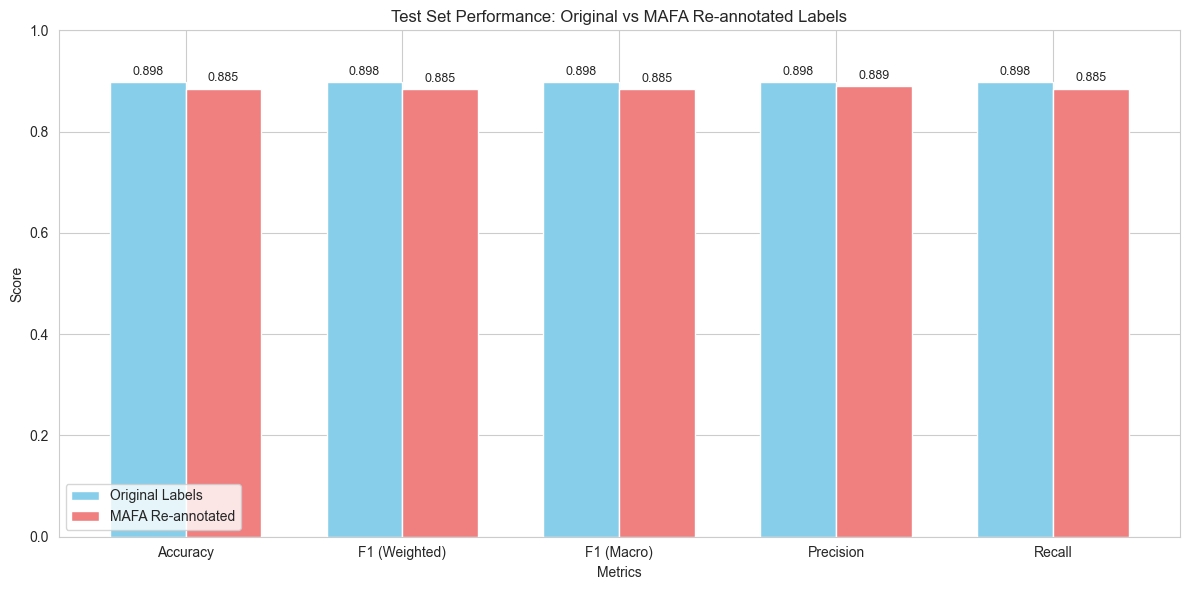

In [38]:
# Visualization
metrics = ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)', 'Precision', 'Recall']
orig_scores = [
    results_orig['test_accuracy'],
    results_orig['test_f1'],
    results_orig['test_f1_macro'],
    results_orig['test_precision'],
    results_orig['test_recall']
]
reann_scores = [
    results_reann['test_accuracy'],
    results_reann['test_f1'],
    results_reann['test_f1_macro'],
    results_reann['test_precision'],
    results_reann['test_recall']
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, orig_scores, width, label='Original Labels', color='skyblue')
bars2 = ax.bar(x + width/2, reann_scores, width, label='MAFA Re-annotated', color='lightcoral')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Test Set Performance: Original vs MAFA Re-annotated Labels')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Thêm giá trị trên bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Chi tiết kết quả trên Test Set

In [39]:
# Classification report chi tiết
print("=== ORIGINAL LABELS - TEST SET ===")
print(classification_report(y_test, results_orig['y_test_pred'], 
                          target_names=['Non-complaint', 'Complaint']))

print("\n=== MAFA RE-ANNOTATED LABELS - TEST SET ===")
print(classification_report(y_test, results_reann['y_test_pred'], 
                          target_names=['Non-complaint', 'Complaint']))

=== ORIGINAL LABELS - TEST SET ===
               precision    recall  f1-score   support

Non-complaint       0.90      0.89      0.90       270
    Complaint       0.89      0.91      0.90       279

     accuracy                           0.90       549
    macro avg       0.90      0.90      0.90       549
 weighted avg       0.90      0.90      0.90       549


=== MAFA RE-ANNOTATED LABELS - TEST SET ===
               precision    recall  f1-score   support

Non-complaint       0.93      0.83      0.88       270
    Complaint       0.85      0.94      0.89       279

     accuracy                           0.89       549
    macro avg       0.89      0.88      0.88       549
 weighted avg       0.89      0.89      0.88       549



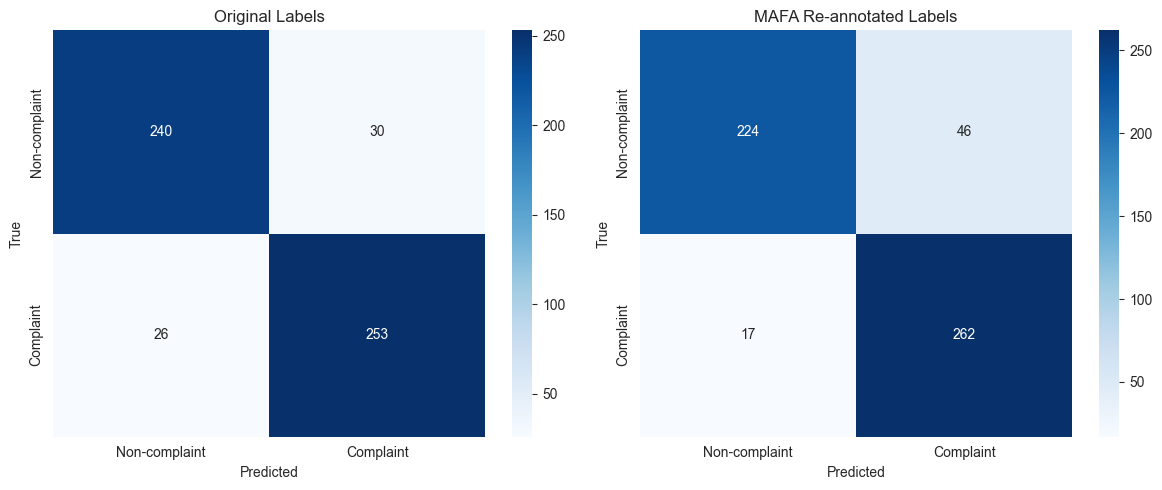

In [40]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_orig = confusion_matrix(y_test, results_orig['y_test_pred'])
cm_reann = confusion_matrix(y_test, results_reann['y_test_pred'])

sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-complaint', 'Complaint'],
            yticklabels=['Non-complaint', 'Complaint'])
axes[0].set_title('Original Labels')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_reann, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Non-complaint', 'Complaint'],
            yticklabels=['Non-complaint', 'Complaint'])
axes[1].set_title('MAFA Re-annotated Labels')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

## 7. Phân tích các trường hợp dự đoán khác nhau

In [41]:
# Tìm các samples mà 2 model dự đoán khác nhau
diff_mask = results_orig['y_test_pred'] != results_reann['y_test_pred']
diff_indices = np.where(diff_mask)[0]

print(f"Số samples mà 2 model dự đoán khác nhau: {len(diff_indices)} / {len(y_test)}")

if len(diff_indices) > 0:
    diff_df = pd.DataFrame({
        'text': X_test.iloc[diff_indices].values,
        'true_label': y_test.iloc[diff_indices].values,
        'pred_orig': results_orig['y_test_pred'][diff_indices],
        'pred_reann': results_reann['y_test_pred'][diff_indices]
    })
    
    # Samples mà Original đúng, Re-ann sai
    orig_correct = diff_df[
        (diff_df['pred_orig'] == diff_df['true_label']) & 
        (diff_df['pred_reann'] != diff_df['true_label'])
    ]
    
    # Samples mà Re-ann đúng, Original sai
    reann_correct = diff_df[
        (diff_df['pred_reann'] == diff_df['true_label']) & 
        (diff_df['pred_orig'] != diff_df['true_label'])
    ]
    
    print(f"\nOriginal đúng, Re-ann sai: {len(orig_correct)}")
    print(f"Re-ann đúng, Original sai: {len(reann_correct)}")
    
    print("\n=== VÍ DỤ: Re-ann đúng, Original sai ===")
    for idx, row in reann_correct.head(5).iterrows():
        print(f"\nText: {row['text'][:150]}...")
        print(f"True: {row['true_label']}, Original pred: {row['pred_orig']}, Re-ann pred: {row['pred_reann']}")

Số samples mà 2 model dự đoán khác nhau: 29 / 549

Original đúng, Re-ann sai: 18
Re-ann đúng, Original sai: 11

=== VÍ DỤ: Re-ann đúng, Original sai ===

Text: giao nhầm đồ rồi cửa hàng ơi...
True: 1, Original pred: 0, Re-ann pred: 1

Text: mặt mình trước khi dùng chỉ có 2 cục mụn thôi.. từ khi bắt đầu sử dụng sản phẩm này.. mụn hiện lên rất nhiều ở 2 bên má và tráng.. chắc do da mình khô...
True: 1, Original pred: 0, Re-ann pred: 1

Text: rất hài lòng với sản phẩm đường may thật chắc không làm tôi thất vọng mà 5star nhà cửa hàng...
True: 0, Original pred: 1, Re-ann pred: 0

Text: trời moá, hàng giả. cứ tưởng giảm giá thiệt, nào ngờ....
True: 1, Original pred: 0, Re-ann pred: 1

Text: hộp ọp ẹp.mất seal.nắp hộp như đã bị mở nhiều lần.chưa dùng thử nên chưa biết hiệu quả ....
True: 1, Original pred: 0, Re-ann pred: 1


## 8. Kết luận

In [42]:
# Tổng kết
print("=" * 60)
print("KẾT LUẬN")
print("=" * 60)

print(f"\n1. AGREEMENT GIỮA 2 BỘ NHÃN:")
print(f"   - {agreement_rate:.2f}% samples có cùng nhãn")
print(f"   - {100-agreement_rate:.2f}% samples bị thay đổi nhãn")

print(f"\n2. HIỆU NĂNG TRÊN TEST SET:")
print(f"   Original Labels:")
print(f"     - Accuracy: {results_orig['test_accuracy']:.4f}")
print(f"     - F1 (Weighted): {results_orig['test_f1']:.4f}")
print(f"     - F1 (Macro): {results_orig['test_f1_macro']:.4f}")
print(f"\n   MAFA Re-annotated Labels:")
print(f"     - Accuracy: {results_reann['test_accuracy']:.4f}")
print(f"     - F1 (Weighted): {results_reann['test_f1']:.4f}")
print(f"     - F1 (Macro): {results_reann['test_f1_macro']:.4f}")

improvement = results_reann['test_f1'] - results_orig['test_f1']
if improvement > 0:
    print(f"\n3. MAFA Re-annotated TỐT HƠN {improvement:.4f} F1 points")
else:
    print(f"\n3. Original Labels TỐT HƠN {abs(improvement):.4f} F1 points")

print("\n4. NHẬN XÉT:")
if agreement_rate > 90:
    print("   - 2 bộ nhãn rất giống nhau (>90% agreement)")
elif agreement_rate > 80:
    print("   - 2 bộ nhãn khá giống nhau (80-90% agreement)")
else:
    print("   - 2 bộ nhãn có sự khác biệt đáng kể (<80% agreement)")

if results_reann['test_f1'] > results_orig['test_f1']:
    print("   - Việc annotate lại bằng MAFA đã CẢI THIỆN chất lượng dữ liệu")
else:
    print("   - Nhãn gốc cho hiệu năng tốt hơn")

print("=" * 60)

KẾT LUẬN

1. AGREEMENT GIỮA 2 BỘ NHÃN:
   - 93.56% samples có cùng nhãn
   - 6.44% samples bị thay đổi nhãn

2. HIỆU NĂNG TRÊN TEST SET:
   Original Labels:
     - Accuracy: 0.8980
     - F1 (Weighted): 0.8980
     - F1 (Macro): 0.8979

   MAFA Re-annotated Labels:
     - Accuracy: 0.8852
     - F1 (Weighted): 0.8848
     - F1 (Macro): 0.8847

3. Original Labels TỐT HƠN 0.0132 F1 points

4. NHẬN XÉT:
   - 2 bộ nhãn rất giống nhau (>90% agreement)
   - Nhãn gốc cho hiệu năng tốt hơn
